### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import xarray as xr

#For plotting
import matplotlib.pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

from importlib import reload

In [2]:
casename = 'skagerak'

from gpuocean.utils import NetCDFInitialization
reload(NetCDFInitialization)
case_info = NetCDFInitialization.getCaseLocation(casename)
case_info.pop("name")

'skagerak'

In [3]:
#s_source_url = "C:\\Users\\florianb\\Downloads\\ocean_his.an.20190716.nc"
s_source_url = "https://thredds.met.no/thredds/dodsC/fou-hi/new_norkyst800m/his/ocean_his.an.20190716.nc"

In [4]:
s_nc = Dataset(s_source_url)

In [5]:
xs = np.arange(case_info["x0"],case_info["x1"])
ys = np.arange(case_info["y0"],case_info["y1"])
t  = 0

In [6]:
s_lvls = s_nc["Cs_r"][:].data
w_lvls = s_nc["Cs_w"][:].data

In [7]:
s_temps = s_nc["temp"][t,:,case_info["y0"]:case_info["y1"],case_info["x0"]:case_info["x1"]]
s_sals  = s_nc["salt"][t,:,case_info["y0"]:case_info["y1"],case_info["x0"]:case_info["x1"]]

In [8]:
s_hs   = s_nc["h"][case_info["y0"]:case_info["y1"],case_info["x0"]:case_info["x1"]]
s_lats = s_nc["lat_rho"][case_info["y0"]:case_info["y1"],case_info["x0"]:case_info["x1"]]

In [9]:
import seawater as sw

In [10]:
s_depths = np.ma.array(np.multiply.outer(s_lvls,s_hs), mask=s_temps.mask.copy())
w_depths = np.ma.array(np.multiply.outer(w_lvls,s_hs), mask=np.array((len(w_lvls)*[s_temps[0].mask.copy()])))

In [11]:
s_pressures = sw.eos80.pres(-s_depths,s_lats)

In [12]:
s_pot_densities = sw.eos80.pden(s_sals,s_temps,s_pressures)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [13]:
thres = 1024

In [299]:
# if all s-levels are heavier than the threshold, then set the upper layer (last index, while argmax fills with 0 in such cases)
mld_base_idx = np.ma.maximum(np.argmax(s_pot_densities < thres, axis=0), (len(s_lvls)-1)*(s_pot_densities[-1] > thres))
# ensure that it is not the base index is not the last level 
mld_base_idx = np.ma.maximum(mld_base_idx, 1)

mld_prog_idx = mld_base_idx-1

In [300]:
mld_depth_base = -np.take_along_axis(s_depths, mld_base_idx.reshape(1,250,500), axis=0)[0]
mld_dens_base = np.take_along_axis(s_pot_densities, mld_base_idx.reshape(1,250,500), axis=0)[0]

mld_depth_prog = -np.take_along_axis(s_depths, mld_prog_idx.reshape(1,250,500), axis=0)[0]
mld_dens_prog = np.take_along_axis(s_pot_densities, mld_prog_idx.reshape(1,250,500), axis=0)[0]

In [301]:
mld = (thres - mld_dens_base)*(mld_depth_prog - mld_depth_base)/(mld_dens_prog - mld_dens_base) + mld_depth_base

In [304]:
mld[s_pot_densities[-1] > thres] = 0

In [313]:
mld = np.ma.minimum(mld, s_hs)
mld = np.ma.maximum(mld, 3)

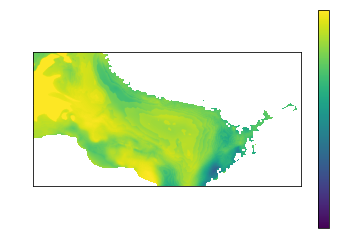

In [315]:
plt.imshow(-mld_depth_prog, vmin=-50, vmax=0, origin="lower")
plt.colorbar()

In [308]:
from scipy.ndimage.filters import convolve, gaussian_filter
#mld = np.ma.array(convolve(np.ma.minimum(mld,-min_mld), [[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]]), mask=s_temps[0].mask.copy())
mld = np.ma.array(gaussian_filter(mld, [1,1]), mask=s_temps[0].mask.copy())

In [309]:
mld = np.ma.minimum(mld, s_hs)
mld = np.ma.maximum(mld, 3)

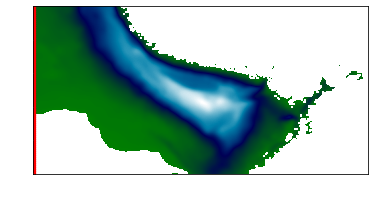

In [310]:
x = 0

plt.imshow(np.ma.array(s_hs, mask=s_temps[0].mask.copy()), origin="lower", cmap="ocean")
plt.scatter(np.repeat(x,len(ys)), np.arange(len(ys)), c="red", s=5.0)

In [311]:
s_pot_densities_show = np.ma.array(np.zeros((len(ys),1000)))
for l in range(len(ys)):
    d_up = 0 
    for i in reversed(range(len(s_lvls))):
        d = round(-(s_hs[l,x]*s_lvls[i]))
        s_pot_densities_show[l,d_up:d] = s_pot_densities[i,l,x]
        d_up = d
s_pot_densities_show.mask = (s_pot_densities_show<0.1)

idxs_show = np.arange(len(s_pot_densities_show.T[0]))[s_pot_densities_show.T[0].mask == False]

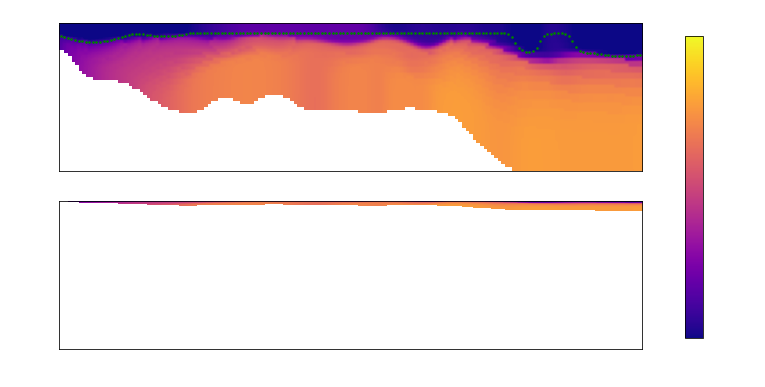

In [312]:
fig, axs = plt.subplots(2,1,figsize=(12,6))

im = axs[0].imshow(s_pot_densities_show.T[0:50,idxs_show], vmin=1024, vmax=1028, cmap="plasma",  aspect='auto')
axs[0].set_ylabel("Depth \n(zoom in)")
axs[0].set_title("Potential Densities")

axs[0].scatter(np.arange(len(idxs_show)),mld[idxs_show,x], c="green", s=2.5)


im = axs[1].imshow(s_pot_densities_show.T[0:700,idxs_show], vmin=1024, vmax=1028, cmap="plasma",  aspect='auto')
axs[1].set_ylabel("Depth \n(full)")
plt.xlabel("Skagen <<<   >>> Arendal")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label="kg/m3")
